# kNN - Find Similar Images

Taken from [here](https://www.kaggle.com/cdeotte/rapids-cuml-knn-find-duplicates)

In [1]:
import math
from glob import glob
import re

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors

import cv2
import matplotlib.pyplot as plt

import efficientnet.tfkeras as efn
import tensorflow as tf
import tensorflow.keras.backend as K

In [2]:
IMG_SIZE = 224
SAMPLE_SIZE = 100
BATCH_SIZE = 64
LOAD_EMBEDDINGS = False
PATH_TO_EMBEDDINGS = "embeddings"

# Create Dataset

In [45]:
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, 3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image/255.0, tf.float32)
    return image, label

In [46]:
TRAIN_PATH = "../data/processed/train/"
TEST_PATH = "../data/processed/test/"

In [47]:
train = [TRAIN_PATH+f"{x}.png" for x in range(SAMPLE_SIZE)]
test = [TEST_PATH+f"{x}.png" for x in range(SAMPLE_SIZE)]

In [48]:
train_df = pd.read_csv(TRAIN_PATH+"corrected_train_data.csv")
train_labels = train_df.sort_values(by="tag")["label"].head(SAMPLE_SIZE).values

test_df = pd.read_csv(TEST_PATH+"sample_submission.csv")
test_labels = test_df.sort_values(by="tag")["label"].head(SAMPLE_SIZE).values

In [49]:
len(train), len(train_labels)

(100, 100)

In [50]:
len(test), len(test_labels)

(100, 100)

In [51]:
train_dataset = tf.data.Dataset.from_tensor_slices((train, train_labels))
train_dataset = train_dataset.map(
    preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [52]:
test_dataset = tf.data.Dataset.from_tensor_slices((test, test_labels))
test_dataset = test_dataset.map(
    preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
test_dataset = test_dataset.batch(BATCH_SIZE)

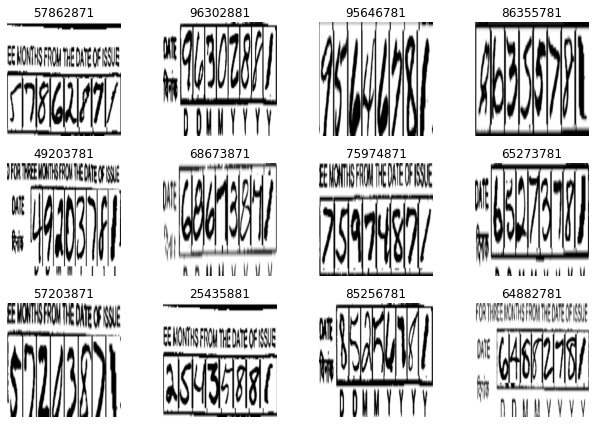

In [53]:
plt.figure(figsize=(9, 6))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy())
        plt.axis("off")
plt.tight_layout()

# Extract Image Features

We will extract image embeddings from ResNet50 using images of size `224x224`. If the variable `LOAD_EMBEDDINGS=True` then we will load them from a previous notebook version Kaggle dataset. If `LOAD_EMBEDDINGS=False`, we will extract them. We normalize our inputs by subtracting ImageNet mean of `0.449` and dividing by ImageNet standard deviation of `0.226`. This is important for image feature extraction because we are not training the EfficientNet anymore. If we were training more, then the model would correct itself if we don't normalize.

In [54]:
def build_model():
    inp = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base = efn.EfficientNetB0(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet", include_top=False)
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    return model

## Test Image Embeddings

In [55]:
if not LOAD_EMBEDDINGS:
    model = build_model()
    embed_test = model.predict(test_dataset, verbose=1)
    np.save(f"embed_test_{IMG_SIZE}", embed_test.astype("float32"))
else:
    embed_test = np.load(PATH_TO_EMBEDDINGS + f"embed_test_{IMG_SIZE}")
print(f"Test Embeddings Shape: {embed_test.shape}")

2/2 [==============================] - 2s 807ms/step
Test Embeddings Shape: (100, 1280)


## Train Image Embeddings

In [56]:
if not LOAD_EMBEDDINGS:
    model = build_model()
    embed_train = model.predict(train_dataset, verbose=1)
    np.save(f"embed_train_{IMG_SIZE}", embed_train.astype("float32"))
else:
    embed_train = np.load(PATH_TO_EMBEDDINGS + f"embed_train_{IMG_SIZE}")
print(f"Train Embeddings Shape: {embed_train.shape}")

2/2 [==============================] - 2s 816ms/step
Train Embeddings Shape: (100, 1280)


# kNN - Find Duplicates

## Find Duplicates

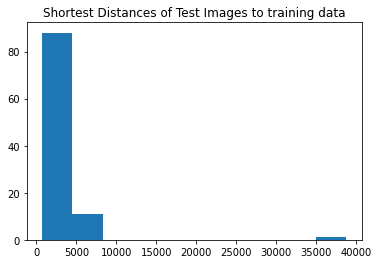

In [57]:
KNN = 5
model = NearestNeighbors(n_neighbors=KNN)
model.fit(embed_train)
distances, indices = model.kneighbors(embed_test)

mm = np.min(distances, axis=1)
plt.title("Shortest Distances of Test Images to training data")
plt.hist(mm)
plt.show()

In [62]:
CUTOFF = 1500
idx = np.where( (mm<CUTOFF) )[0]
print('There are %i potential duplicate images that have distance < %i'%(len(idx),CUTOFF))

There are 6 potential duplicate images that have distance < 1500


## Display Duplicates

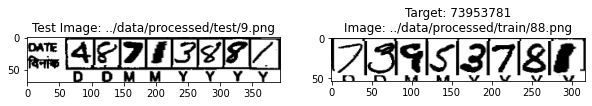

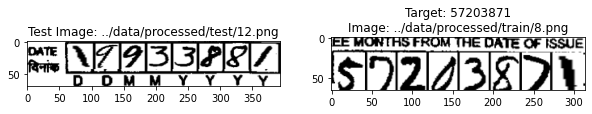

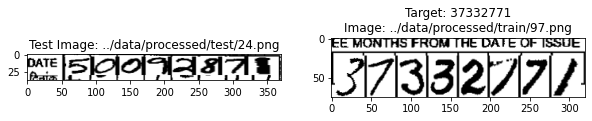

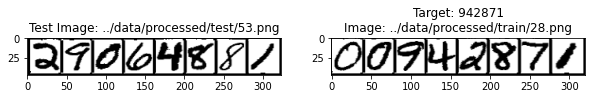

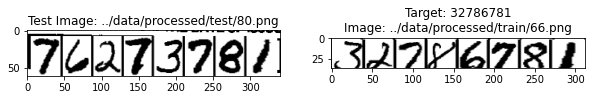

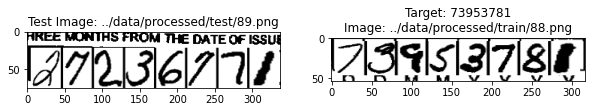

In [63]:
for k in idx:
    plt.figure(figsize=(10, 5))    
    plt.subplot(1, 2, 1)
    img = cv2.imread(test[k])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Test Image: {test[k]}")

    plt.subplot(1, 2, 2)
    img = cv2.imread(train[int(indices[k, 0])])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    t = train_labels[int(indices[k, 0])]
    plt.title(f"Target: {t}\nImage: {train[int(indices[k, 0])]}")
    
    plt.show()